# Script to generate BEM thrust profile for the diagram in the Torque paper

In [1]:
from pathlib import Path
import os
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

from MITRotor.ReferenceTurbines import IEA15MW
from MITRotor.BEM import BEM
from MITRotor.Geometry import BEMGeometry
from scipy.optimize import minimize


rootdir = Path(os.getcwd()).parent.parent
figdir = rootdir / Path("fig")
figdir.mkdir(exist_ok=True, parents=True)


rotor = IEA15MW()
bem = BEM(rotor, BEMGeometry(10, 200))

In [2]:
def find_optimal_setpoint(bem: BEM, yaw: float = 0) -> Tuple[float, float, float]:
    def to_opt(x):
        pitch, tsr = x
        return -bem(pitch, tsr, yaw).Cp()

    res = minimize(to_opt, (0, 8))
    pitch, tsr = res.x

    return np.array([pitch, tsr, yaw], dtype=float)

In [3]:
# Calculate optimal setpoints
pitch_opt, tsr_opt, _ = find_optimal_setpoint(bem)

print("optimal θ_p [deg]: ", np.rad2deg(pitch_opt))
print("optimal λ: ", tsr_opt)


optimal θ_p [deg]:  -1.437757513666056
optimal λ:  8.96394409559048


In [4]:
# Generate rotor distribution in yawed inflow


YAW = np.deg2rad(40)

sol = bem(pitch_opt, tsr_opt, YAW)

mu_mesh = bem.geometry.mu_mesh
theta_mesh = bem.geometry.theta_mesh

X, Y = mu_mesh * np.cos(theta_mesh), mu_mesh * np.sin(theta_mesh)


Z = sol.solidity(grid="radial")[..., None] * sol.W(grid="full") ** 2 * sol.Cax(grid="full")


## Plotting

/tmp/ipykernel_54638/2720633100.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(


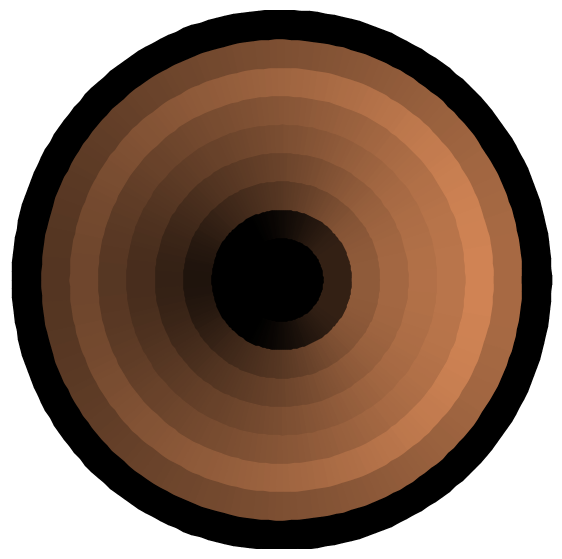

In [5]:
plt.figure(figsize=(7, 7))

thres = 0.6


plt.pcolormesh(
    X,
    Y,
    Z,
    edgecolors="face",
    antialiased=True,
    cmap="copper",
    vmin=thres,
    vmax=1.2,
)
# plt.colorbar()
plt.axis("equal")
plt.axis("off")
plt.savefig(figdir / "thrust_distribution.png", dpi=400, bbox_inches="tight")
